In [6]:
# imports and loading
import pandas as pd
import sys
sys.path.append('/home/chris/github/Strainware-s/')
sys.path.append('/home/chris/github/Strainware-s/bitome2/')
import bitome
from bitome.core import Bitome
from workflows_CAD.feature_functions import *
import pickle
import logomaker
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# settings
testing = True
small_dataset = True # only use the first 50 samples, mostly useful when using a limited license
pull_best_paras = False # pull best results from parameter_optimization, else use defaults


# load in settings flags
if testing:
    flags_filepath = '../options/test_gene_flags.csv'
    TF_flags_filepath = '../options/test_TF_flags.csv'
else:
    flags_filepath = '../options/gene_flags.csv'
    TF_flags_filepath = '../options/TF_flags.csv'
flags_df = pd.read_csv(flags_filepath, index_col = 0)
flags_df = pd.read_csv(flags_filepath, index_col = 0)
flags_df = flags_df[flags_df['include'] == True]

# loading
bitome_genbank = Bitome('../data/external/sequence_info/NC_000913.3.gb')
bitome_fasta = Bitome('../data/external/sequence_info/NC_000913.3.fasta')
tu_table = pd.read_csv('../data/external/sequence_info/tu.csv')
tf_pwm_db = rpwm('../data/external/sequence_info/motif_pwm_db.txt')
tfbs = pd.read_csv('../data/external/sequence_info/TFBS_regulondb.csv')

TF_flags_df = pd.read_csv(TF_flags_filepath, index_col = 0)

pickle_in = open('../data/interim/misc_dictionaries/gene_to_operon_to_motif_scores_dist_to_TSS.pkl', 'rb')
gene_to_operon_to_motif_scores_dist_to_TSS = pickle.load(pickle_in)
pickle_in.close()

Alias location.position is deprecated and will be removed in a future release. Use location directly, or int(location). However, that will fail for UnknownPosition, and for OneOfPosition and WithinPosition will give the default rather than left-most value.


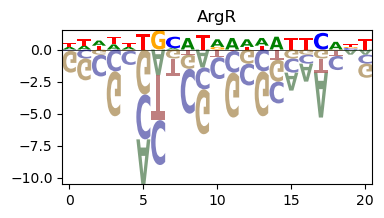

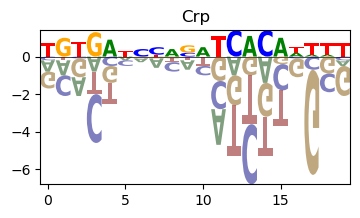

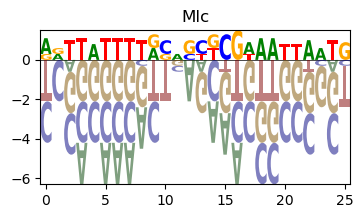

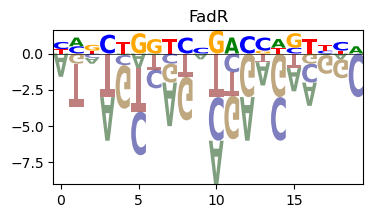

In [7]:
# plotting search motif
for gene in TF_flags_df.TF:
    gene = gene[0].upper()+gene[1:]
    if gene not in tf_pwm_db:
        continue
    gene_to_operon_to_motif_scores_dist_to_TSS.update({gene : {}})
    gene_pwm_old = tf_pwm_db[gene]
    
    motif_df = pd.DataFrame(gene_pwm_old)
    fig, ax = plt.subplots(1,1,figsize=[4, 2])
    # create Logo object
    logo = logomaker.Logo(motif_df, ax = ax,
                              shade_below=.5,
                              fade_below=.5,)
                              #font_name='Arial Rounded MT Bold')
    ax.set_title(gene)
    plt.savefig('../figures/'+gene+'_overall_logo.pdf', transparent = True)
    plt.show()
    plt.close()

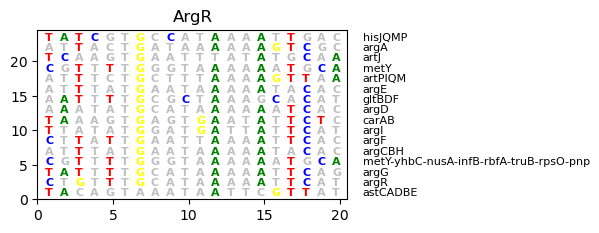

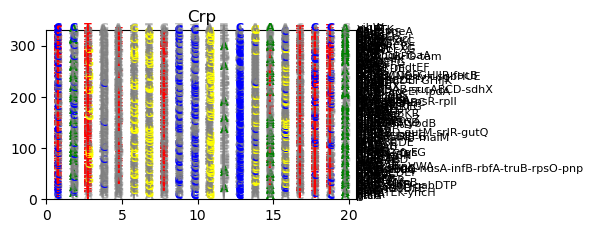

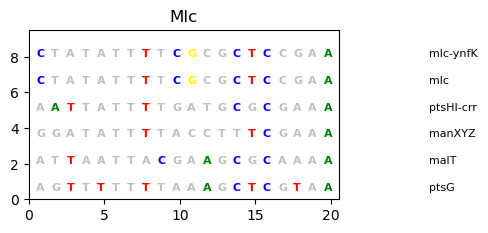

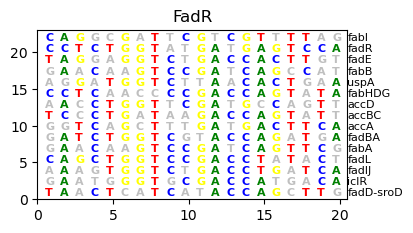

In [8]:
# plotting individual best matches
letter_to_color = {
    'T' : 'red',
    'A' : 'green',
    'G' : 'yellow',
    'C' : 'blue',
}

for gene in TF_flags_df.TF:
    gene = gene[0].upper()+gene[1:]
    predicted_df = pd.read_pickle('../data/interim/bitome_results/'+gene+'.pkl')
    plt.figure(figsize = [4, 2.2])
    y = .5
    TUs_temp = list(predicted_df.TU)
    TUs = []
    _ = [TUs.append(x) for x in TUs_temp if x not in TUs]
    for TU in TUs:
        bby = predicted_df[predicted_df['TU'] == TU].sort_values('Score').iloc[-1]
        if len(bby.Match_sequence) == 0:
            continue
        for x in motif_df.index:
            good_letters = motif_df.columns[motif_df.loc[x] > 0].to_list()
            if bby.Match_sequence[x] in good_letters:
                color = letter_to_color[bby.Match_sequence[x]]
                alpha = 1
            else:
                color = 'grey'
                alpha = 0.5
            plt.text(y = y, x = x + .5, s = bby.Match_sequence[x], alpha = alpha, color = color, fontsize = 8, weight = 'bold')
        plt.text(y = y, x = len(bby.Match_sequence) + .5, fontsize = 8, s = TU)
        y += 1.5
    plt.xlim([0, len(motif_df.index) + .5])
    plt.ylim([0, y])
    plt.title(gene)
    plt.savefig('../figures/'+gene+'motif_matches.pdf', transparent = True)
    plt.show()